# Upgrading the Backdoor Algorithm  

We have two objectives in the notebook.  First is to better understand the mechanics of the existing back door identification algorithm at work in DoWhy.  The second is to plan out and execute and improvement which gives the expected answers to the five games below.  A tertiary goal may be to create a method for generating fake data based on a given graph.  The existing fake data generator is not very robust.

In [1]:
import pandas as pd
import numpy as np
import daft
import dowhy
from dowhy.do_why import CausalModel
from dowhy.causal_graph import CausalGraph
from dowhy.datasets import stochastically_convert_to_binary
import networkx as nx
import statsmodels.api as sm

In [163]:
# Helper functions adapted to work with numpy arrays. 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def stochastically_convert_to_binary(x):
    ps = sigmoid(x)
    return np.hstack([np.random.choice([0, 1], 1, p=[1-p, p]) for p in ps])

def stachastically_combine(parents):
    # We define this in this way so that we can work with an arbitrary
    # number of parents.
    # This intercept centers the mean of the values around 0.5
    size = len(parents[0])
    #output = np.ones(size)*-0.25*(len(parents)-1)
    #for p in parents:
    #    output += 0.5*p
    output = np.mean(parents, axis=0)
    return stochastically_convert_to_binary(output)

In [164]:
a = np.random.choice(2, 100)
b = np.random.choice(2, 100)
c = np.random.choice(2, 100)
stachastically_combine([a, b, c])

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [165]:
def binary_graph_data(treatment_name='X', outcome_name='Y', observed_node_names=['X', 'Y'], ate=1, graph=None, n_obs=1000):
    """Generates data from a provided causal graph.  
    
    For simplicity, all variables are binary.
    
    Args:
        treatment_name (string): name of the treatment variable in the provided graph
        outcome_name (string): name of the outcome variable in the provided graph
        observed_node_names (list): list of all nodes in the graph for which we will generate data
        ate (float): the actual treatment effect.  Currently doesn't work. I'm not sure how I would implement it.
        graph (string): the graph provided in either GML or DOT format
    Returns:
        ret_dict (dictionary): a dictionary of the desired dataframe and some of the input 
                               parameters to match the other dataset generators
    """
   
    def generate_data(observed_node_names, parents, children, data={}, var=None):
        """Recursive algorithm to generating data

        Get a random var from the list and check it's parents and children. 
        If the node has no parents
            binary data is generated at random and recursively runs on a child
        Else 
            it checks if data has been generated for all parents, and 
                if not, runs itself on the parent.  
            If data has been generated for all parents, then
                it creates a linear column of data dependant on its parents. 
        """    
        if var is None:
            # Allows us to not specify a var to start with
            var = observed_node_names.pop()

        p, c = parents[var], children[var]  

        if var in data.keys():
            pass
        elif p == set():
            # If it has no parents, then it's a root node. Randomly generate it.
            #print(f"Generating {var}")
            data[var] = np.random.choice(2, n_obs)
            try:
                # Remove it from the list of variables left to generate
                observed_node_names.remove(var)
            except:
                pass
        else:
            # If the selected node is not a root, then it needs to be checked
            # to ensure that all parents have been calculated
            for parent in list(p):
                if parent not in data.keys():
                    generate_data(observed_node_names, parents, children, data=data, var=parent)

            # Finally, if all parents have data, then we can generate data for this node
            parent_data = [data[parent] for parent in list(p)]
            #print(f"Generating {var}")
            data[var] = stachastically_combine(parent_data)

        if observed_node_names != []:
            child = observed_node_names.pop()
            generate_data(observed_node_names, parents, children, data=data, var=child)

        return pd.DataFrame(data)
    
    cgraph = CausalGraph(treatment_name=treatment_name, outcome_name=outcome_name, graph=graph, observed_node_names=observed_node_names)
    # We don't care about unobserved confounders in this dataset, so we generate the unobserved
    # subgraph and work with that.
    obs_graph = cgraph.get_unconfounded_observed_subgraph()
    # Saves us from calling .predecessors and descendants a bunch
    parents = {var: set(obs_graph.predecessors(var)) for var in observed_node_names}
    children = {var: set(nx.descendants(obs_graph, var)) for var in observed_node_names}
    
    data = generate_data(observed_node_names, parents, children)
    
    ret_dict = {
        "df": data,
        "treatment_name": treatment_name,
        "outcome_name": outcome_name,
        "graph": graph,
        "ate": ate
    }
    return ret_dict

## Example 1: Book of Why Backdoor Games

These games all come from Chapter 4 of the Book of Why.  They are devoid of context, but the graphical model is given and our only job is to identify the set of backdoor paths from X to Y.  I will use these games as unit tests of the behavior of DoWhy's backdoor algorithm.

### Game 1

This relatively trivial game has no backdoor paths. 

In [166]:
graph_dot = "digraph {X -> A;A -> Y;A -> B;}"
observed_node_names = ["B", "X", "Y", "A"]

data = binary_graph_data(observed_node_names=observed_node_names, graph=graph_dot)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.do_why:Model to find the causal effect of treatment X on outcome Y
INFO:dowhy.causal_graph:Using Matplotlib for plotting


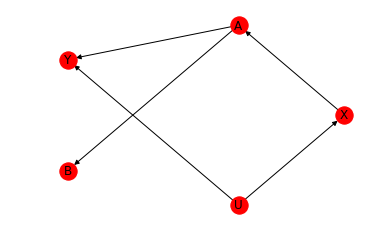

In [167]:
graph_dot = "digraph {X -> A;A -> Y;A -> B;}"
observed_node_names = ["B", "X", "Y", "A"]

data = binary_graph_data(observed_node_names=observed_node_names, graph=graph_dot)

game_one = CausalModel(
                data=data['df'],
                treatment=data['treatment_name'],
                outcome=data['outcome_name'],
                graph=data['graph'])

game_one.view_model()

In [168]:
identified_estimand = game_one.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                  
──(Expectation(Y|))
dX                 
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,,U) = P(Y|X,)
### Estimand : 2
Estimand name: iv
No such variable found!



In [130]:
# Unfortunate that this generates an error.  
lr_estimate = game_one.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

ValueError: No objects to concatenate

In [169]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['df']['Y'], exog=sm.tools.add_constant(data['df']['X']))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.429
Date:                Thu, 14 Mar 2019   Prob (F-statistic):            0.00653
Time:                        16:11:20   Log-Likelihood:                -684.24
No. Observations:                1000   AIC:                             1372.
Df Residuals:                     998   BIC:                             1382.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5931      0.022     27.457      0.0

### Game 2
Introduces a backdoor path, but it's already blocked!

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.do_why:Model to find the causal effect of treatment A on outcome Y
INFO:dowhy.causal_graph:Using Matplotlib for plotting


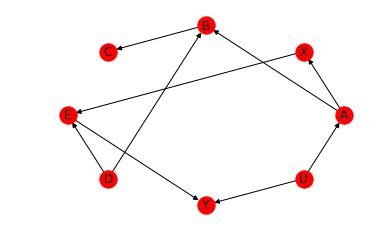

In [189]:
graph_dot = "digraph {A -> X;A -> B;B -> C;X -> E;D -> B;D -> E;E -> Y}"
observed_node_names = ['X', 'A', 'Y', 'B', 'C', 'D', 'E']

data = binary_graph_data(observed_node_names=observed_node_names, graph=graph_dot, treatment_name='A')

game_two = CausalModel(
                data=data['df'],
                treatment=data['treatment_name'],
                outcome=data['outcome_name'],
                graph=data['graph'])

game_two.view_model()

In [192]:
identified_estimand = game_two.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                  
──(Expectation(Y|))
dA                 
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,,U) = P(Y|A,)
### Estimand : 2
Estimand name: iv
No such variable found!



In [193]:
lr_estimate = game_two.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

ValueError: No objects to concatenate

The identified estimand, $Y \sim X+A$, is again not what we expect.  It is treating A as an instrumental variable... I'm not sure that this is totally correct, though the back door paths from A to Y are blocked and thus we aren't actually introducing bias by controlling for A.  However, since the only backdoor path from X to Y is blocked by the collider at B we don't need to control for A in the first place, which was the answer that I expected from the algorithm.

In [191]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['df']['Y'], exog=sm.tools.add_constant(data['df'][['A']]))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.090
Date:                Thu, 14 Mar 2019   Prob (F-statistic):              0.297
Time:                        16:17:01   Log-Likelihood:                -680.69
No. Observations:                1000   AIC:                             1365.
Df Residuals:                     998   BIC:                             1375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6605      0.021     32.142      0.0

### Game 3

This game finally introduces a backdoor path which requires us to control for a variable.

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.do_why:Model to find the causal effect of treatment X on outcome Y
INFO:dowhy.causal_graph:Using Matplotlib for plotting


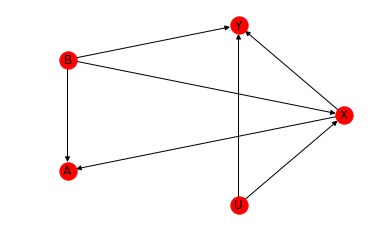

In [194]:
graph_dot = "digraph {X -> Y;B -> X;B -> Y;X -> A;B -> A;}"

observed_node_names = ['X', 'A', 'Y', 'B']

data = binary_graph_data(observed_node_names=observed_node_names, graph=graph_dot)

game_three = CausalModel(
                data=data['df'],
                treatment=data['treatment_name'],
                outcome=data['outcome_name'],
                graph=data['graph'])

game_three.view_model()

In [195]:
identified_estimand = game_three.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'B']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|B))
dX                  
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,B,U) = P(Y|X,B)
### Estimand : 2
Estimand name: iv
No such variable found!



In [196]:
lr_estimate = game_three.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~X+B


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|B))
dX                  
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,B,U) = P(Y|X,B)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~X+B
## Estimate
Value: 0.10343313624921756

Causal Estimate is 0.10343313624921756


In [197]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['df']['Y'], exog=sm.tools.add_constant(data['df'][['X', 'B']]))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     17.43
Date:                Thu, 14 Mar 2019   Prob (F-statistic):           3.62e-08
Time:                        16:17:58   Log-Likelihood:                -660.12
No. Observations:                1000   AIC:                             1326.
Df Residuals:                     997   BIC:                             1341.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5334      0.025     21.009      0.0

This one worked great.  Appropriately controls for B. 

### Game 4

This graph is designed specifically as a trap called "M-bias".  Many statisticians would control for B.  What would DoWhy do?

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.do_why:Model to find the causal effect of treatment X on outcome Y
INFO:dowhy.causal_graph:Using Matplotlib for plotting


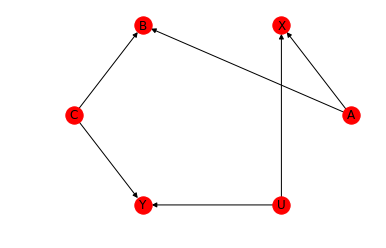

In [198]:
graph_dot = "digraph {A -> X;A -> B;C -> B;C -> Y;}"

observed_node_names = ['X', 'A', 'Y', 'B', 'C']

data = binary_graph_data(observed_node_names=observed_node_names, graph=graph_dot)

game_four = CausalModel(
                data=data['df'],
                treatment=data['treatment_name'],
                outcome=data['outcome_name'],
                graph=data['graph'])

game_four.view_model()

In [199]:
identified_estimand = game_four.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['A']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                  
──(Expectation(Y|))
dX                 
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,,U) = P(Y|X,)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, A)/Derivative(X, A))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→A)
Estimand assumption 2, Exclusion: If we remove {A}→X, then ¬(A→Y)



In [73]:
lr_estimate = game_four.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

LinearRegressionEstimator


ValueError: No objects to concatenate

In [200]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['df']['Y'], exog=sm.tools.add_constant(data['df'][['X']]))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2860
Date:                Thu, 14 Mar 2019   Prob (F-statistic):              0.593
Time:                        16:18:17   Log-Likelihood:                -697.49
No. Observations:                1000   AIC:                             1399.
Df Residuals:                     998   BIC:                             1409.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6070      0.024     25.013      0.0

DoWhy get's this one solidly.  No need to control for anything, and if the model is working right then we should detect no effect as there is no causal line from X to Y.   

### Game 5

Our final, and most challenging game.  There are two possible solutions, either C alone can be closed or A and B. Let's see what it determines. 

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.do_why:Model to find the causal effect of treatment X on outcome Y
INFO:dowhy.causal_graph:Using Matplotlib for plotting


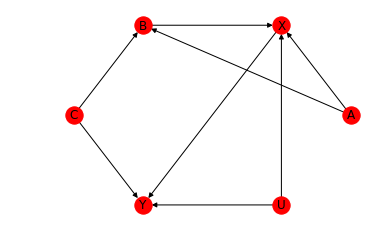

In [206]:
graph_dot = "digraph {A -> X;A -> B;C -> B;C -> Y;B -> X; X -> Y}"

observed_node_names = ['X', 'A', 'Y', 'B', 'C']

data = binary_graph_data(observed_node_names=observed_node_names, graph=graph_dot, n_obs=1000)

game_five = CausalModel(
                data=data['df'],
                treatment=data['treatment_name'],
                outcome=data['outcome_name'],
                graph=data['graph'])

game_five.view_model()

In [208]:
identified_estimand = game_five.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['A', 'C', 'B', 'U']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['A']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                       
──(Expectation(Y|A,C,B))
dX                      
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,A,C,B,U) = P(Y|X,A,C,B)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, A)/Derivative(X, A))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→A)
Estimand assumption 2, Exclusion: If we remove {A}→X, then ¬(A→Y)



In [209]:
lr_estimate = game_five.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~X+A+C+B


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                       
──(Expectation(Y|A,C,B))
dX                      
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,A,C,B,U) = P(Y|X,A,C,B)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, A)/Derivative(X, A))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→A)
Estimand assumption 2, Exclusion: If we remove {A}→X, then ¬(A→Y)

## Realized estimand
b: Y~X+A+C+B
## Estimate
Value: 0.11190830206093398

Causal Estimate is 0.11190830206093398


In [210]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['df']['Y'], exog=sm.tools.add_constant(data['df'][['X', 'C']]))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     15.43
Date:                Thu, 14 Mar 2019   Prob (F-statistic):           2.51e-07
Time:                        16:20:18   Log-Likelihood:                -672.11
No. Observations:                1000   AIC:                             1350.
Df Residuals:                     997   BIC:                             1365.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5054      0.028     17.957      0.0

It gives a correct answer, but not nearly the best.  Controlling for C would have been minimally sufficient, and A + B would have been a second best.  It makes me wonder about the logic internally, and why it doesn't aim towards the simplest solutions.  I would like to update the implementation, good practice in anticipation of the front door adjustment.  I have already played with an algorithm that more or less matches what was outlined [in this presentation](https://www.ssc.wisc.edu/~felwert/causality/wp-content/uploads/2013/06/2-elwert_dags.pdf).  For the complete identifcation algorithm we look to the [Ph.D. thesis of Ilya Shpitser](https://ftp.cs.ucla.edu/pub/stat_ser/shpitser-thesis.pdf), which provides a complete algorithm for identifying of a causal estimate can be identified.  Studying it will probably be helpful, particular if we want to be able to include the front-door in our estimands. 